<a href="https://colab.research.google.com/github/shkwo-n/Leather-Anomaly-Detection-CV/blob/main/MVTEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import cv2 # OpenCV
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision
from torchvision import models

import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torchsummary import summary

import torch.nn.functional as F
import torch.optim as optim
import time
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Custom Dataset 만들기

#### From Train Folder

In [3]:
root_dir="/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/"

In [4]:
train1_file_list = glob.glob(root_dir + "*")

train1_data = []

for class_path in train1_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        train1_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(train1_data))

245


In [5]:
train1_data[0]

['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png',
 'good']

(1024, 1024)

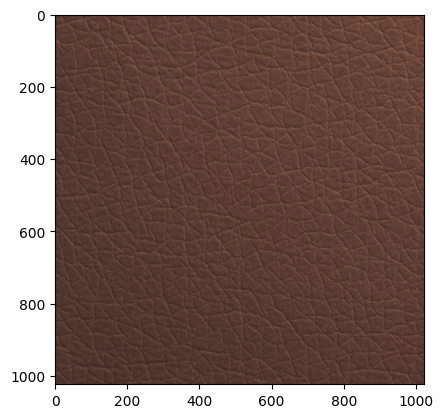

In [6]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png')
plt.imshow(img)
img.size

In [7]:
img = cv2.imread('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png', cv2.IMREAD_COLOR)
img.shape

(1024, 1024, 3)

#### From Test Folder

In [8]:
root_dir = "/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/"

# Retrieve the list of ALL folders and files inside the base folder
train2_file_list = glob.glob(root_dir + "*")

train2_data = []
# Create a list that would contain the paths to all the images in the dataset
for class_path in train2_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        train2_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(train2_data))

124


In [9]:
train_data=[]

train_data.extend(train1_data)
train_data.extend(train2_data)

len(train_data)

369

In [10]:
class CustomData(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"good":0,"color" : 1, "cut": 2,"fold":3, "glue":4, "poke":5}
        # Set image dimensions
        self.img_dim = (1024, 1024)
        # Perform any transformations
        self.transform= transform
        self.normal_transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label, e.g. 0 (for "Dog")
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if class_id !=0:
            img_tensor = self.transform(pil_img)
        else:
            img_tensor = self.normal_transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id)

        return img_tensor, class_id

In [11]:
transform_anomaly=transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.2),
                                      transforms.RandomHorizontalFlip(p=5),
                                      transforms.RandomVerticalFlip(p=5),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

transform_normal=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [12]:
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_set, test_set = torch.utils.data.random_split(train_data, [train_size, test_size])

trainset = CustomData(train_set, transform=transform_anomaly)

testset = CustomData(test_set, transform=transform_normal)

train_loader = DataLoader(trainset, batch_size=24,
                          shuffle=True, num_workers=2, pin_memory=True)

test_loader = DataLoader(testset, batch_size=24,
                          shuffle=False, num_workers=2, pin_memory=True)

##### Augmentation 확인

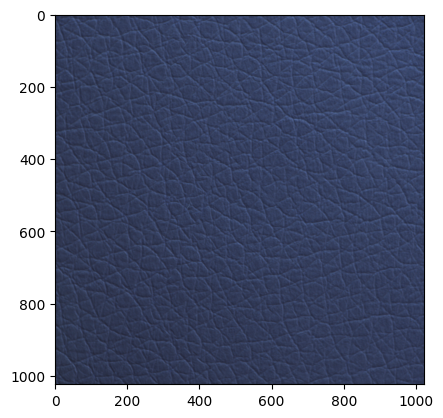

In [13]:
# extract image data
image_data = trainset[0][0]

# normalize image data from 0 to 1
if image_data.min() < 0.0:
    image_data = (image_data + 1.0) / 2.0

plt.imshow(image_data.permute(1, 2, 0))
plt.show()

### Model FineTuning

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

# 2. ResNet 모델 불러오기
# 미리 학습된 ResNet 모델 불러오기
resnet = torchvision.models.resnet18(pretrained=True)

# ResNet의 fully connected layer를 다시 구성하여 새로운 클래스 개수에 맞게 조정
num_classes = 6  # 0에서 5까지 총 6개의 클래스
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

# 3. Optimizer와 손실 함수 설정
# Fine-tuning 시에는 주로 작은 학습률을 사용합니다.
learning_rate = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

# CrossEntropyLoss를 사용하여 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 4. Fine-tuning 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Fine-tuning을 위한 함수 정의
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy

# 테스트 함수 정의
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_predictions += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy

# 5. Fine-tuning 학습 및 테스트
num_epochs = 10
for epoch in range(num_epochs):
    # Fine-tuning 학습
    train_loss, train_accuracy = train(resnet, train_loader, criterion, optimizer, device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

    # 테스트
    test_loss, test_accuracy = test(resnet, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

print("Fine-tuning이 완료되었습니다.")
